In [1]:
from __future__ import print_function,division
from builtins import range,input

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense,Embedding,Input,LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD


Using TensorFlow backend.


#### Configuration

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25


#### Load the data

In [3]:
input_texts = []
target_texts = []
for line in open("data/robert_frost.txt",encoding = 'utf8'):
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos> ' + line
    target_line = line +' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)
    
all_lines = input_texts + target_texts



#### Convert the sentences (strings) into integers

- If we don't assgin filters, it will filter all special characters

In [4]:

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters = '')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

#### Find max seq length

In [5]:
max_sequence_length_from_data  =max(len(s) for s in input_sequences)
print("Max Length: ",max_sequence_length_from_data )

Max Length:  12


#### Get word -> integer mapping

In [6]:
word2idx = tokenizer.word_index
print('Found %s unique tokens. ' %len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3057 unique tokens. 


#### pad sequences so that we got a N * T matrix

In [7]:
max_sequence_length = min(max_sequence_length_from_data,MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences,maxlen = max_sequence_length,padding = 'post')
target_sequences = pad_sequences(target_sequences,maxlen = max_sequence_length,padding = 'post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


#### Load in pre-trained word vectors

In [8]:
word2vec = {}
with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype = 'float32')
        word2vec[word] = vec
print('Found %s word vectors.' %len(word2vec))

num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i <MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            

Found 400000 word vectors.


#### One-hot the targets (can't use sparse cross_entropy due to sequence target)

- (number of samples, step, word feature matrix)

In [9]:
one_hot_targets = np.zeros((len(input_sequences),max_sequence_length,num_words))
for i, target_sequence in enumerate(target_sequences):
    for t,word in enumerate(target_sequence):
        if word >0:
            one_hot_targets[i,t,word] = 1
            
        

#### Load pre-trained word embeddings into an Embedding layer

In [10]:
embedding_layer = Embedding(
num_words,
EMBEDDING_DIM,
weights = [embedding_matrix])


#### Build LSTM network

In [11]:
input_ = Input(shape = (max_sequence_length,))
initial_h = Input(shape = (LATENT_DIM,))
initial_c = Input(shape = (LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM,return_sequences = True,return_state = True)
x,_,_ = lstm(x,initial_state = [initial_h,initial_c])
dense = Dense(num_words,activation = 'softmax')
output  = dense(x)

model = Model([input_,initial_h,initial_c],output)
model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(lr = 0.01),
             metrics = ['accuracy'])

z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences,z,z],
             one_hot_targets,
             batch_size = BATCH_SIZE,
             epochs = EPOCHS,
             validation_split = VALIDATION_SPLIT,
             verbose = 0)




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


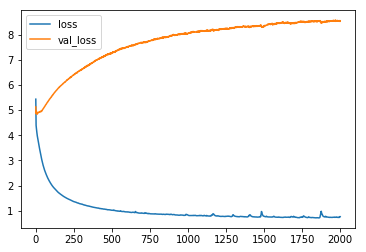

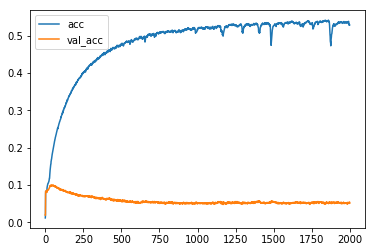

In [12]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

#### Make a sampling model

In [13]:
input2 = Input(shape = (1,))   ## only input one word at a time
x = embedding_layer(input2)
x,h,c=  lstm(x,initial_state = [initial_h,initial_c])  ## now we need states to feed back
output2 = dense(x)
sampling_model = Model([input2,initial_h,initial_c],[output2,h,c])


In [14]:
#### Reverse word2idx dictionary to get back words during prediction

idx2word = {v:k for k,v in word2idx.items()}



In [15]:
def sample_line():
    ### initial inputs
    np_input = np.array([[word2idx['<sos>']]])
    h = np.zeros((1,LATENT_DIM))
    c = np.zeros((1,LATENT_DIM))
    
    ## so we know when to quit
    eos = word2idx['<eos>']
    
    ## store the output here
    output_sentence = []
    for _ in range(max_sequence_length):
        o,h,c = sampling_model.predict([np_input,h,c])
        
        ### o is a 3 dim data with (1,1,word vectors)
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print('wtf')
        probs[0] = 0   ## Don't let idx = 0 happen
        probs /= probs.sum()  ## renormalize probability
        idx = np.random.choice(len(probs),p = probs)
        if idx == eos:
            break
            
        ### accumulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' %idx))
        
        ## make the next input into model
        np_input[0,0] = idx
        
    return ' '.join(output_sentence)



#### Generate the result

In [16]:
for i in range(4):
    
     print(sample_line())
    
    

or something brushed across earth and music around the joints, though,
against the' attic door: the door is get up; i'm too warm
the past and i come to it.
but he snapped all summer,


In [17]:
np_input = np.array([[word2idx['<sos>']]])
h = np.zeros((1,LATENT_DIM))
c = np.zeros((1,LATENT_DIM))
o,h,c = sampling_model.predict([np_input,h,c])
        

In [ ]:
o.shape